In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [5]:
train_cols = [
    "engine_displacement",
    "horsepower",
    "vehicle_weight",
    "model_year",
]
pred_col = "fuel_efficiency_mpg"
df = pd.read_csv(
    "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv",
    usecols=train_cols + [pred_col],
)

<Axes: >

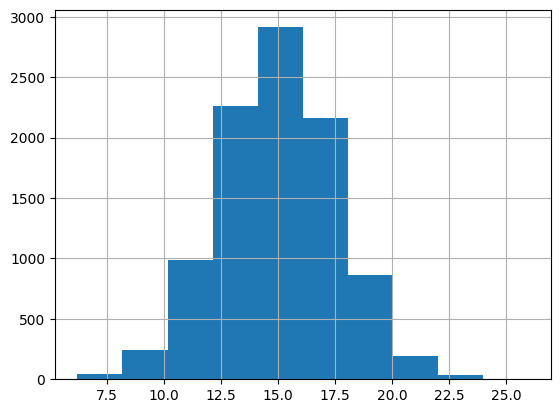

In [10]:
df[pred_col].hist()

In [7]:
df.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [8]:
df.horsepower.median()

np.float64(149.0)

In [9]:
# train test split without using sklearn
import numpy as np

np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)  # 20%
n_test = int(0.2 * n)  # 20%
n_train = n - (n_val + n_test)  # 60%

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val :].copy()

print(
    f"Train: {(df_train.shape[0] / n):.2%}",
    f"Val: {(df_val.shape[0] / n):.2%}",
    f"Test: {(df_test.shape[0] / n):.2%}",
    sep="\n",
)

Train: 60.02%
Val: 19.99%
Test: 19.99%


In [11]:
y_train = df_train[pred_col].values
y_val = df_val[pred_col].values
y_test = df_test[pred_col].values

# linear regression

In [12]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [14]:
def prepare_X(df: pd.DataFrame, cols: list[str], fill_value: float) -> np.ndarray:
    df_num = df[cols]
    df_num = df_num.fillna(fill_value)
    X = df_num.values
    return X

## using 0 for fillna

In [15]:
X_train = prepare_X(df=df_train, cols=train_cols, fill_value=0)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

In [16]:
def rmse(y, y_pred) -> float:
    error = y_pred - y
    mse = (error**2).mean()
    return np.sqrt(mse)

In [17]:
score = rmse(y_train, y_pred)
print(f"{score=:.2f}")

score=0.52


In [18]:
X_val = prepare_X(df_val, cols=train_cols, fill_value=0)
y_pred = w_0 + X_val.dot(w)
score = rmse(y_val, y_pred)
print(f"{score=:.2f}")

score=0.52


## using mean of train for fillna

In [19]:
# since only horsepower has NAs
X_train = prepare_X(df_train, cols=train_cols, fill_value=df_train.horsepower.mean())
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

In [20]:
score = rmse(y_train, y_pred)
print(f"{score=:.2f}")

score=0.46


In [21]:
X_val = prepare_X(df_val, cols=train_cols, fill_value=df_train.horsepower.mean())
y_pred = w_0 + X_val.dot(w)
score = rmse(y_val, y_pred)
print(f"{score=:.2f}")

score=0.46


# Regularization

In [22]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [30]:
X_train = prepare_X(df_train, cols=train_cols, fill_value=0)
scores = []
for r in [0, 0.01, 1, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_train.dot(w)
    score = rmse(y_train, y_pred)
    scores.append(score)
    print(f"{r=:.2f}, {w_0=:.2f}, {score=:.8f}")

r=0.00, w_0=28.83, score=0.52026143
r=0.01, w_0=24.93, score=0.52042184
r=1.00, w_0=1.73, score=0.52794703
r=10.00, w_0=0.18, score=0.52884326
r=100.00, w_0=0.02, score=0.52894139


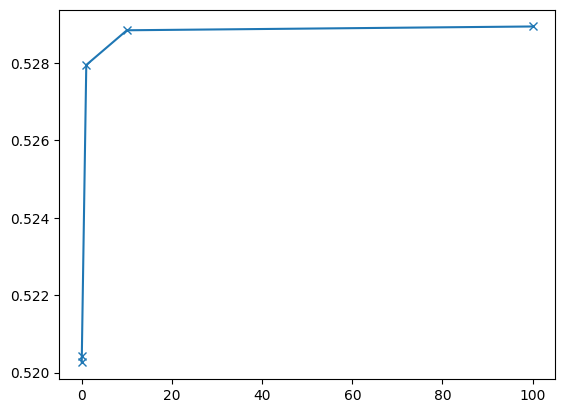

In [37]:
import matplotlib.pyplot as plt

plt.plot([0, 0.01, 1, 10, 100], scores, "x-")

In [73]:
scores = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val :].copy()

    y_train = df_train[pred_col].values
    y_val = df_val[pred_col].values
    y_test = df_test[pred_col].values

    X_train = prepare_X(df_train, cols=train_cols, fill_value=0)
    X_val = prepare_X(df_val, cols=train_cols, fill_value=0)

    # train model
    w_0, w = train_linear_regression(X=X_train, y=y_train)

    # predict on val
    y_pred = w_0 + X_val.dot(w)

    # calc rmse
    score = rmse(y=y_val, y_pred=y_pred)
    scores.append(score)
    print(f"{seed=}, {w_0=:.2f}, {score=:.8f}")

print(f"{np.std(scores)=:.3f}")

seed=0, w_0=27.38, score=0.52065313
seed=1, w_0=29.02, score=0.52133889
seed=2, w_0=25.90, score=0.52280700
seed=3, w_0=28.02, score=0.51595167
seed=4, w_0=25.93, score=0.51091295
seed=5, w_0=25.90, score=0.52834065
seed=6, w_0=25.92, score=0.53139107
seed=7, w_0=28.41, score=0.50906704
seed=8, w_0=26.48, score=0.51473991
seed=9, w_0=27.51, score=0.51318659
np.std(scores)=0.007


In [ ]:
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)

n = len(df)

n_test = int(0.2 * n)  # 20%
n_train = n - n_test # 80%

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val :].copy()

y_train = df_train[pred_col].values
y_val = df_val[pred_col].values
y_test = df_test[pred_col].values
